In [70]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
from torchvision.transforms import functional as F

In [71]:
#padding to square 
def pad_to_square(image):
    width, height = image.size
    max_wh = max(width, height)
    padding = [
        (max_wh - width) // 2,      # Left
        (max_wh - height) // 2,     # Top
        (max_wh - width + 1) // 2,  # Right
        (max_wh - height + 1) // 2  # Bottom
    ]
    return F.pad(image, padding, fill=0)
def bounding_box(image):
    gray_image = image.convert("L")
    binary_image = gray_image.point(lambda p: p > 0 and 255)
    bbox = binary_image.getbbox()
    return bbox
def crop_to_square(image):
    bbox = bounding_box(image)
    if bbox:
        left,top,right,bottom = bbox
        width, height = right - left, bottom - top
        max_size = max(width, height)
        new_left = left - (max_size - width) // 2
        new_top = top - (max_size - height) // 2
        new_right = new_left + max_size
        new_bottom = new_top + max_size
        return image.crop((new_left, new_top, new_right, new_bottom))
    return image

In [72]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: pad_to_square(img)),
    transforms.Lambda(lambda img: crop_to_square(img)),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [73]:
dataset = datasets.ImageFolder(root='./Datasets', transform=transform)

In [74]:
print(dataset.class_to_idx)

{'no': 0, 'yes': 1}


In [75]:
train_size = int(0.6*len(dataset))
test_size = int(len(dataset)*0.2)
val_size = len(dataset) - test_size - train_size

In [76]:
from torch.utils.data import random_split
data_train, data_test, data_val = random_split(dataset, [train_size,test_size,val_size])

In [77]:
train_loader = DataLoader(data_train, batch_size=64, shuffle=True)
test_loader =  DataLoader(data_test, batch_size=64, shuffle=False)
val_loader =  DataLoader(data_val, batch_size=64, shuffle=False)


In [78]:
import torch.nn as nn
import torch.optim  as optim
import torch.nn.functional as f
# tính kích thước đầu ra:(Input Size−Kernel Size+2*padding)/S + 1
# (inputsize- kernel size)/s+1
#xây dựng mô hình CNN
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Conv2D layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # MaxPooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        def get_output_size(input_size):
            size = input_size
            size = (size - 3 + 2 * 1) // 1 + 1  # Conv layer
            size = (size - 2) // 2 + 1  # MaxPooling layer
            size = (size - 3 + 2 * 1) // 1 + 1  # Conv layer
            size = (size - 2) // 2 + 1  # MaxPooling layer
            size = (size - 3 + 2 * 1) // 1 + 1  # Conv layer
            size = (size - 2) // 2 + 1  # MaxPooling layer
            return size

        input_size = 64
        output_size = get_output_size(input_size)
        self.fc1 = nn.Linear(64 * output_size * output_size, 64)
        self.fc2 = nn.Linear(64, 1)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(f.relu(self.conv1(x)))
        x = self.pool(f.relu(self.conv2(x)))
        x = self.pool(f.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = f.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  
        return x
model = CNNModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [79]:
def calculate_accuracy(predictions, labels):
    predictions = torch.sigmoid(predictions)
    predicted_classes = (predictions > 0.5).float()  # Convert probabilities to class labels
    correct = (predicted_classes == labels).sum().item()
    return correct

In [80]:
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies =[]

In [81]:
for epoch in range(200):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    totalt = 0
    total_samples_in_epoch = len(train_loader) * train_loader.batch_size
    for i, (inputs, labels) in enumerate(train_loader, 0):
        optimizer.zero_grad()  # xóa gradient cũ
        
        outputs = model(inputs)
        
        labels = labels.unsqueeze(1).float()  # Ensure labels have the correct shape and type
        correct_train += calculate_accuracy(outputs,labels)
        loss = criterion(outputs, labels) 
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss.item()
        totalt += labels.size(0)
        

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = correct_train / totalt
    train_accuracies.append(train_accuracy)
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            
            labels = labels.unsqueeze(1).float()
            correct_in = calculate_accuracy(outputs, labels)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            total += labels.size(0)
            correct += (correct_in)  # Accumulate accuracy
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    accuracy_percentage = (correct*100 / total) if total > 0 else 0
    val_accuracies.append(accuracy_percentage/100)
    print(f'Accuracy on epoch: {epoch} validation dataset: {accuracy_percentage:.2f}%')

print('Finished Training')

Accuracy on epoch: 0 validation dataset: 62.00%
Accuracy on epoch: 1 validation dataset: 75.50%
Accuracy on epoch: 2 validation dataset: 83.17%
Accuracy on epoch: 3 validation dataset: 79.33%
Accuracy on epoch: 4 validation dataset: 91.00%
Accuracy on epoch: 5 validation dataset: 91.17%
Accuracy on epoch: 6 validation dataset: 92.83%
Accuracy on epoch: 7 validation dataset: 92.83%
Accuracy on epoch: 8 validation dataset: 94.67%
Accuracy on epoch: 9 validation dataset: 96.17%
Accuracy on epoch: 10 validation dataset: 96.67%
Accuracy on epoch: 11 validation dataset: 96.50%
Accuracy on epoch: 12 validation dataset: 96.33%
Accuracy on epoch: 13 validation dataset: 96.50%
Accuracy on epoch: 14 validation dataset: 97.00%
Accuracy on epoch: 15 validation dataset: 96.33%
Accuracy on epoch: 16 validation dataset: 97.33%
Accuracy on epoch: 17 validation dataset: 98.00%
Accuracy on epoch: 18 validation dataset: 98.00%
Accuracy on epoch: 19 validation dataset: 97.33%
Accuracy on epoch: 20 validati

In [87]:
#torch.save(model, 'BrainTumorbyTorch.pth')

In [88]:
import matplotlib.pyplot as plt

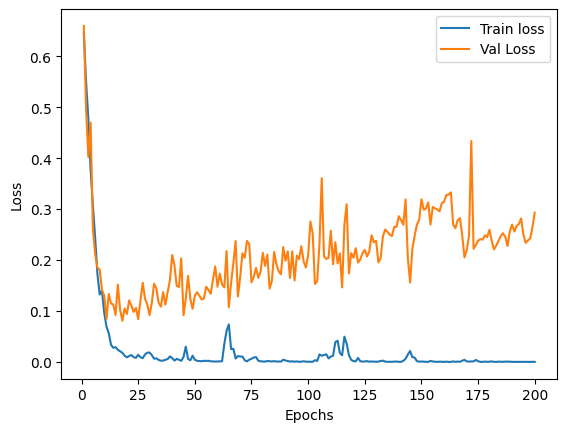

In [89]:
plt.plot(range(1,201),train_losses,label ='Train loss')
plt.plot(range(1,201), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [90]:
print(train_accuracies)

[0.6133333333333333, 0.7127777777777777, 0.7805555555555556, 0.8394444444444444, 0.8761111111111111, 0.9077777777777778, 0.9338888888888889, 0.95, 0.9472222222222222, 0.9716666666666667, 0.9783333333333334, 0.9816666666666667, 0.99, 0.9916666666666667, 0.9911111111111112, 0.9922222222222222, 0.9916666666666667, 0.995, 0.9966666666666667, 0.9983333333333333, 0.9961111111111111, 0.995, 0.9988888888888889, 0.9983333333333333, 0.9955555555555555, 0.9966666666666667, 0.9983333333333333, 0.9938888888888889, 0.9927777777777778, 0.9927777777777778, 0.9972222222222222, 0.9983333333333333, 0.9972222222222222, 0.9994444444444445, 1.0, 0.9988888888888889, 0.9988888888888889, 0.9977777777777778, 0.9972222222222222, 0.9972222222222222, 0.9988888888888889, 0.9983333333333333, 0.9983333333333333, 0.9994444444444445, 0.9972222222222222, 0.99, 0.9988888888888889, 0.9994444444444445, 0.9961111111111111, 0.9994444444444445, 0.9994444444444445, 0.9994444444444445, 0.9994444444444445, 0.9994444444444445, 0.

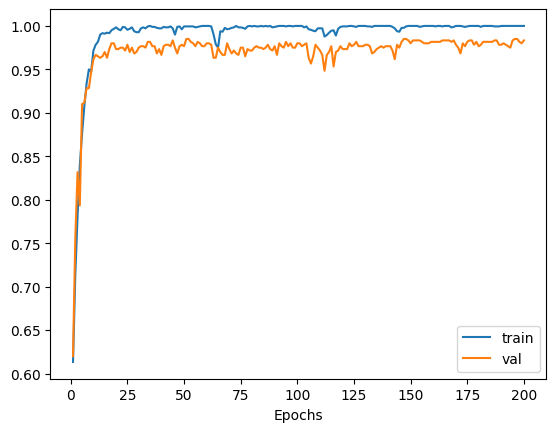

In [91]:
plt.plot(range(1,201),train_accuracies,label = 'train')
plt.plot(range(1,201),val_accuracies,label = 'val')
plt.xlabel('Epochs')
plt.ylabel('')
plt.legend()